In [1122]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from scipy.cluster.hierarchy import centroid, fcluster
from scipy.spatial.distance import pdist
import imageio

Task 3: Clustering spatial data. The input is a raster (in jpg format) and a list of points (in raster coordinates). It is necessary to combine "close" points into clusters and display each cluster on the raster with one icon.

Optional: the ability to set the degree of "proximity". Optional: displays the number of origin points that fall into each of the clusters.

Test data generation.

In [1147]:
path = "D://"

In [2154]:
img = np.full((1000, 1000, 3), fill_value = 255, dtype='uint8') # ndarray that represent image 1000x1000 size filled white color

In [2155]:
# generate n clouds of dots on the (img.shape[0] x img.shape[1]) plane
dots = []  # empty lists of dots coordinates
n = 10 # number of clouds
m = 10 # number of dots in each cloud
for i in range(n):
    x = np.random.randint(0, img.shape[1])  # rnd coordinates of cloud 
    y = np.random.randint(0, img.shape[0])
    m1 = np.random.randint(5, 10)  # random multiplier for cloud variance
    m2 = np.random.randint(5, 10)
    x_var = img.shape[0] // m1  # variance along axis
    y_var = img.shape[1] // m2
    x_coord = np.random.randn(m) * x_var + x  #coordinates for dots of cloud
    y_coord = np.random.randn(m) * y_var + y
    
    # filling plain with dots
    for i in range(x_coord.shape[0]):
        xi = x_coord[i]
        yi = y_coord[i]
        if xi >= img.shape[1]:
            xi = img.shape[1] - 4
        if yi >= img.shape[0]:
            yi = img.shape[0] - 4
        if xi < 0:
            xi = 4
        if yi < 0:
            yi = 4
        dots.append([int(yi), int(xi)])
        # img[int(yi) - 2 : int(yi) + 2, int(xi) - 2 : int(xi) + 2, :] = 0  # place dots on image
# imageio.imwrite(os.path.join(path, "1.png"), img)  # write image to file for visualization

In [2156]:
dots_np = np.asarray(dots)  # converting to ndarray
dots_df = pd.DataFrame(dots_np, columns=["y", "x"]) # as DataFrame

I used a centroid linkage. Centroid and ward linkages work well with the cloud-like data. Depends on the type of data the other approaches of clusterization may be more suitable.

In [2157]:
dm = pdist(dots)  # condensed distance matrix

In [2158]:
dg = centroid(dm) # linkage of dm with centroid method

Optimisation of distance parameter for clusterization with fcluster

In [2159]:
mean_dist = dm.mean()  # mean distance between all dots on plot

In [2160]:
start = 5
step = 10
dist_range = range(start, int(mean_dist) + 2 * step, step) # the steps of distance

In [2161]:
average_meandist = [] # list to collect averaged inner group distances for each step of distance
cluster_number = [] # list to collect numbers of clusters for each step of distance
for dist in dist_range:
    # fcluster returns array of clusters numbers for each observation in dg for current dist
    clust_list = pd.Series(fcluster(dg, dist, criterion='distance')) # list of clusters indexes
    cluster_number.append(clust_list.nunique()) # nuber of clusters for current dist
    dots_df["clust_list"] = clust_list # df to select observations wich belong to current cluster index
    list_nclust_meandist = []  # list to collect inner group mean distances for each cluster
    for nclust in dots_df.clust_list.unique():
        clust_size =dots_df[clust_list == nclust][["y", "x"]].shape[0]
        if clust_size > 1:  # cluster of one dot don't have mean distance
            nclust_meandist = pdist(dots_df[clust_list == nclust][["y", "x"]]).mean() # inner group distance for each cluster
            list_nclust_meandist.append(nclust_meandist)
        else:
            list_nclust_meandist.append(0)
    average_meandist.append(pd.Series(list_nclust_meandist).mean())
dots_df = dots_df.drop("clust_list", axis=1)

In [2162]:
# increasment of averaged mean dist for each step of distance
av_meandist_incr = np.array(average_meandist)[1:] - np.array(average_meandist)[0:-1]

In [2163]:
# df to combine all data for analysis
analysis_df = pd.DataFrame({"dist": dist_range[1:], 
                            "av_meandist_incr": av_meandist_incr, "cluster_number": pd.Series(cluster_number)[1:]})

<AxesSubplot:xlabel='dist', ylabel='av_meandist_incr'>

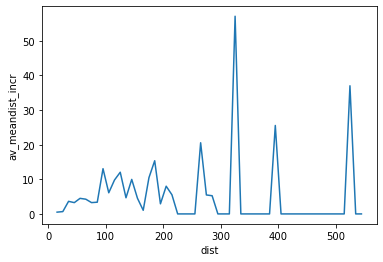

In [2164]:
sns.lineplot(data=analysis_df, x="dist", y="av_meandist_incr")

There are many ways to calculate cut-off criteria for the level of clusterization. The choice depends on the type of data we are analyzing. One of them is the average inner group mean distance. It works well when the clusters are well separated and close in size. When the increasing of the average inner group mean distance becomes zero it means that no additional points for this step of distance.
There are two variations of this aproach:

Distance for the first step with 0 increasing of averaged inner group mean distance to find the case with maximum diversity of clusterization. To avoid clustering on separete dots there is a special check for condition = if the mean number of dots > 1.5 

In [2165]:
i = 0
while True:
    cut2 = analysis_df[analysis_df["av_meandist_incr"] == 0].dist.iloc[i]
    dots_df["list2"] = fcluster(dg, cut2, criterion='distance')
    list2_unique = dots_df["list2"].unique()
    if dots_df.list2.value_counts().mean() >= 1.5:
        break
    i += 1

In [2166]:
# compute centroids coordinates
clusters2 = []
for i in list2_unique:
    n = dots_df[dots_df.list2 == i][["y", "x"]].shape[0]
    if n > 1:
        y, x = dots_df[dots_df.list2 == i][["y", "x"]].mean()
    else:
        y, x = dots_df[dots_df.list2 == i][["y", "x"]].iloc[0]
    clusters2.append([int(y), int(x)])

In [2167]:
# print a label in center of cut2 clusters
# to do: draw a numbers 0-9 to be printed as labels on plot
for i in clusters2:
    y, x = i    
    img[y - 3 : y + 4, x - 3 : x + 4, :] = \
                            [[[255, 0, 0], [255,0,0], [255,0,0], [255,0,0], [255,0,0], [255,0,0], [255,0,0]], 
                            [[255, 0, 0], [255,255,255], [255,255,255], [255,255,255], [255,255,255], [255,255,255], [255,0,0]],
                            [[255, 0, 0], [255,255,255], [255,255,255], [255,255,255], [255,255,255], [255,255,255], [255,0,0]],
                            [[255, 0, 0], [255,255,255], [255,255,255], [255,255,255], [255,255,255], [255,255,255], [255,0,0]],
                            [[255, 0, 0], [255,255,255], [255,255,255], [255,255,255], [255,255,255], [255,255,255], [255,0,0]],
                            [[255, 0, 0], [255,255,255], [255,255,255], [255,255,255], [255,255,255], [255,255,255], [255,0,0]],
                            [[255, 0, 0], [255,0,0], [255,0,0], [255,0,0], [255,0,0], [255,0,0], [255,0,0]]]

In [2168]:
# Distance for the first step of the longest interval with a constant number of clusters. Find the most separated clusters.
nclust_find = analysis_df[analysis_df["av_meandist_incr"] == 0].cluster_number.value_counts().head(1).index[0]
cut1 = analysis_df[analysis_df.cluster_number == nclust_find].dist.iloc[0]
dots_df["list1"] = fcluster(dg, cut1, criterion='distance')
list1_unique = dots_df["list1"].unique()

# Color labeling for cut1 clusters. Up to 7 clusters.
# to do: more colors 
colors = [[255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 0], [0, 255, 255], [255, 0, 255], [0, 0, 0]]
if len(list1_unique) <=7: 
    for i in list1_unique:
        for line in range(dots_df[dots_df.list1 == i].shape[0]):
            y, x = dots_df[dots_df.list1 == i][["y", "x"]].iloc[line]
            img[y - 2 : y + 2, x - 2 : x + 2, :] = colors[i - 1]

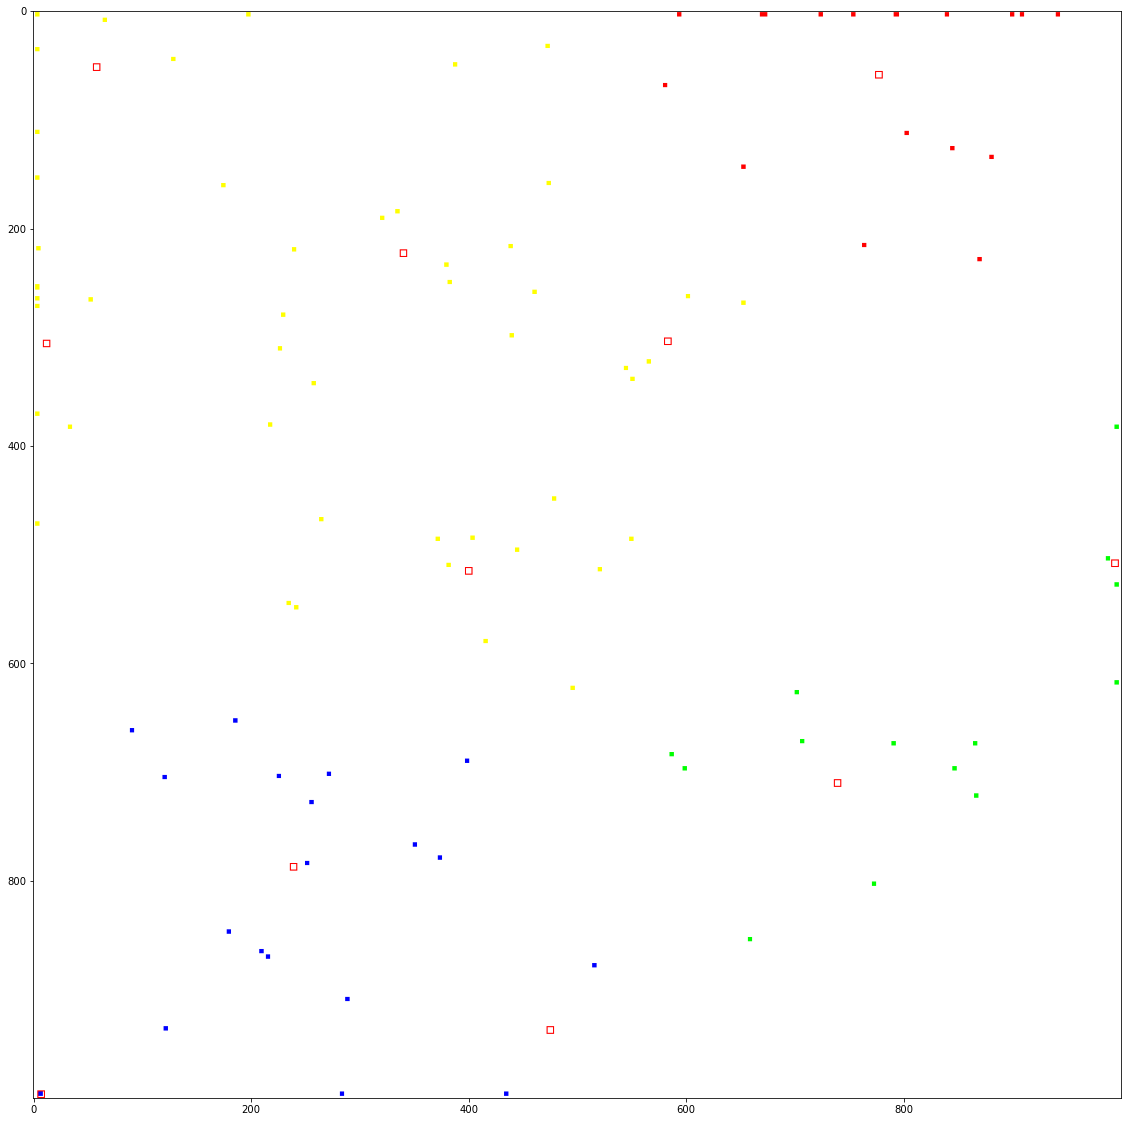

In [2169]:
fig = plt.figure(figsize=(20, 20))
plt.imshow(img)

In [1704]:
# write image to file
# imageio.imwrite(os.path.join(path, "2.tiff"), img)

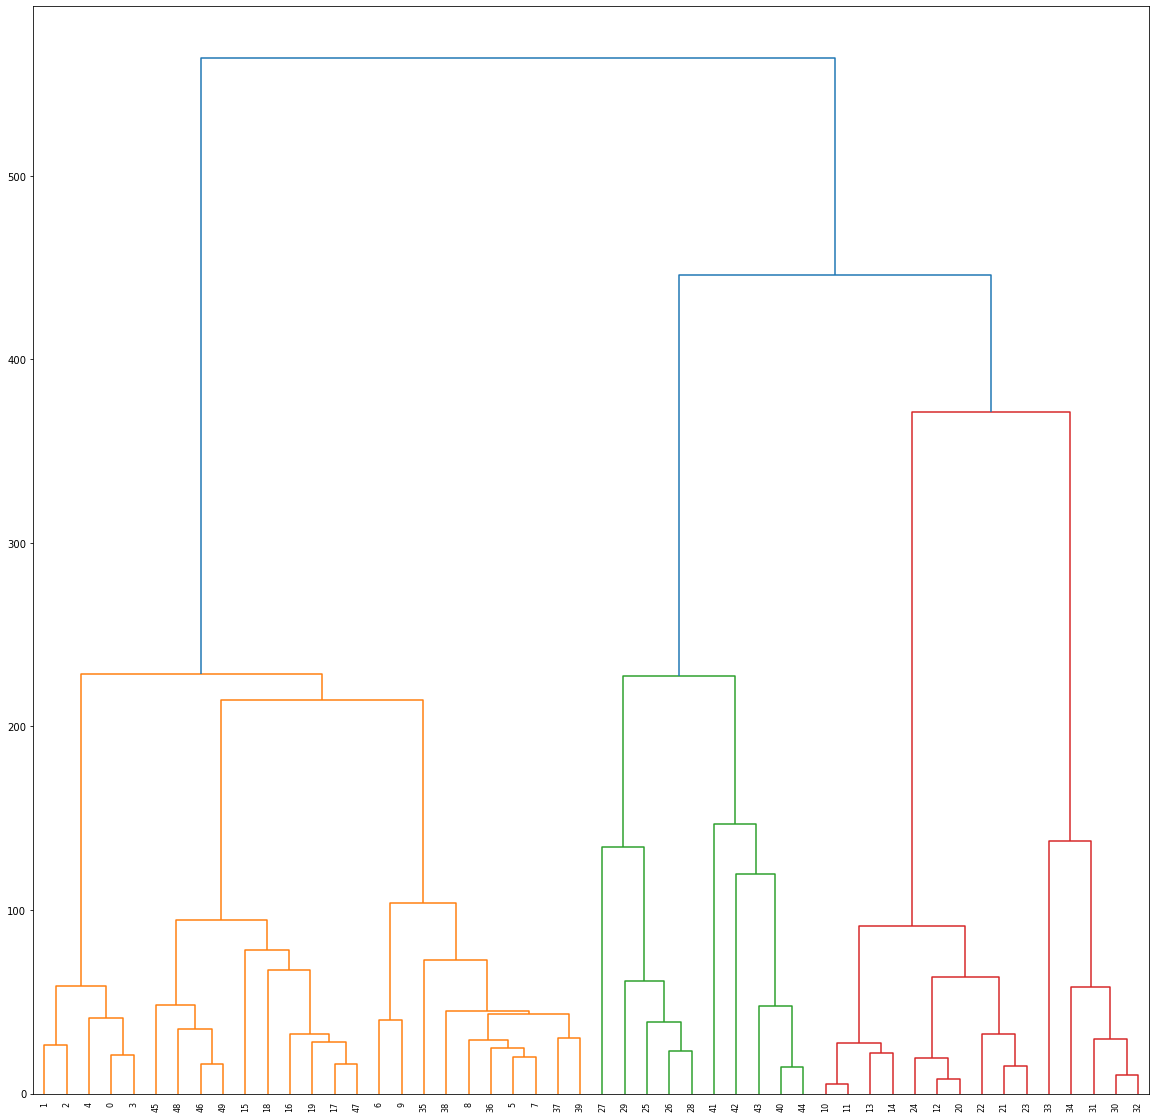

In [1678]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

z = linkage(dm, 'centroid')
fig = plt.figure(figsize=(20, 20))
dn = dendrogram(z)

In [2088]:
list2_unique

array([1], dtype=int32)